
### Price Trajectories
Modeled by [Wiener Process](https://en.wikipedia.org/wiki/Wiener_process)

### Data:
#### The Graph (Compound-v2)
Used for current total borrowed

#### Coingecko (Historical Prices)
Use file: `data/coingeckoe_prices.csv`

Created by download script `download_historical_prices.py`. The script has a runtime of ~1h, because it sends about 600 requests to coingecko. The free API allows 10-50 requests / minute, so I use a sleep of 6 seconds to never send more than 10 requests / minute. 

Time window: `2022-11-21` to `2022-11-20`

Should be updated if gets too old compared to the timestamp of data from The Graph. 


## Assumptions

- total supply = total borrows + free
- when asset is twice in graph list (wbtc, dai) only take the one with bigger borrows, drop the other
- exchange rate and collateral factor don't change

## documentation
- If an asset has a 0% collateral factor, it can’t be used as collateral (or seized in liquidation), though it can still be borrowed.

In [1]:
import pandas as pd
from pathlib import Path
import json

from src.coingecko import CoingeckoAPI
from src.the_graph import TheGraphAPI

PRICES_FILE = Path.cwd().joinpath("data", "coingecko_prices.csv")
PARAMS_FILE = Path.cwd().joinpath("configs", "parameters.json")


In [2]:
# get current Compound Borrows from The Graph

tg_api = TheGraphAPI()
borrows = tg_api.get_compound_borrows()

col_dtypes = {
    "underlyingSymbol":str,
    "underlyingName":str, 
    "totalBorrows":float,	
    "totalSupply":float,
    "collateralFactor":float,	
    "exchangeRate":float,
    "underlyingPriceUSD":float,	
    "blockTimestamp":int,
    }
borrows_df = pd.DataFrame(borrows)
borrows_df = borrows_df.apply(lambda c: c.astype(col_dtypes[c.name]))
borrows_df

,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp
0,USDP,Pax Dollar,0.000,0.020194,1.973558e+04,1.473143e+06,1.000000,1669103195
1,TUSD,TrueUSD,0.000,0.020552,5.487149e+06,3.924372e+08,1.000000,1669103147
2,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731
3,UNI,Uniswap,0.750,0.020299,4.302101e+05,2.187284e+08,5.026058,1669117823
4,USDC,USD//C,0.855,0.022679,2.569819e+08,2.992931e+10,1.000000,1669118027
5,SUSHI,SushiToken,0.700,0.020470,6.625741e+05,1.403626e+08,1.102776,1669117979
6,ETH,Ether,0.825,0.020076,1.377320e+04,1.835529e+07,1082.307226,1669117811
7,DAI,Dai Stablecoin,0.835,0.022105,1.816402e+08,1.789512e+10,1.000529,1669118135
8,BAT,Basic Attention Token,0.650,0.020676,4.445937e+05,7.201187e+09,0.212466,1669114283
9,COMP,Compound,0.650,0.020414,1.034897e+04,3.062481e+07,36.310000,1669116695


Have two entries for `DAI` and `wBTC` each... only keep the bigger one for now
```
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin",
  "borrowRate": "0.0233026004452608",
  "totalBorrows": "211524161.923877439677332104",
  "collateralFactor": "0.835",
  "underlyingPriceUSD": "1.000773",
  "blockTimestamp": 1669045535,
  "accrualBlockNumber": 16019369
},
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin v1.0 (DAI)",
  "borrowRate": "0.0501467542606656",
  "totalBorrows": "240.64852988575940222",
  "collateralFactor": "0",
  "underlyingPriceUSD": "6.210826",
  "blockTimestamp": 1668979619,
  "accrualBlockNumber": 16013904
},
....
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0206864728473312",
  "totalBorrows": "0.39387562",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "15929.996902",
  "blockTimestamp": 1669001867,
  "accrualBlockNumber": 16015751
},
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0221761103560704",
  "totalBorrows": "152.21575285",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "16182.771321",
  "blockTimestamp": 1669043411,
  "accrualBlockNumber": 16019192
},
```

In [3]:
borrows_df = borrows_df.sort_values(by=["underlyingSymbol", "totalBorrows"], ascending=False).reset_index(drop=True)
borrows_df = borrows_df.drop_duplicates(subset=["underlyingSymbol"])
borrows_df

,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp
0,ZRX,0x Protocol Token,0.650,0.020591,4.962345e+05,4.944923e+08,0.175700,1669117751
1,YFI,yearn.finance,0.750,0.020265,3.181422e-02,7.085534e+03,6194.460000,1668777299
2,WBTC,Wrapped BTC,0.700,0.020072,1.565218e+02,7.824679e+05,15740.040000,1669117607
4,USDT,Tether USD,0.000,0.022045,1.647356e+08,1.040939e+10,1.000000,1669117127
5,USDP,Pax Dollar,0.000,0.020194,1.973558e+04,1.473143e+06,1.000000,1669103195
6,USDC,USD//C,0.855,0.022679,2.569819e+08,2.992931e+10,1.000000,1669118027
7,UNI,Uniswap,0.750,0.020299,4.302101e+05,2.187284e+08,5.026058,1669117823
8,TUSD,TrueUSD,0.000,0.020552,5.487149e+06,3.924372e+08,1.000000,1669103147
9,SUSHI,SushiToken,0.700,0.020470,6.625741e+05,1.403626e+08,1.102776,1669117979
10,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731


### Monte Carlo Simulation
- Calculate Volatilties
- Simulate Price Paths

In [32]:
from src.measures import calc_volatility, monte_carlo_simulation

with open(PARAMS_FILE) as f:
    params = json.load(f)
    
# load historical prices from coingecko (used scrip `download_historica_prices.ipynb` to prepare data)
prices = pd.read_csv(PRICES_FILE)
symbols = prices["symbol"].unique()

# calculate volatilities
vols = {}
for symbol in symbols:
    p = prices[prices["symbol"] == symbol]["price"].values
    vols[symbol] = calc_volatility(p)

print(vols)

{'usdp': 0.0043466418878502005, 'tusd': 0.00282056858179138, 'rep': 0.07171938656321616, 'uni': 0.0697395479254225, 'usdc': 0.0021574718617547875, 'sushi': 0.09514300836715131, 'eth': 0.06422278659986509, 'dai': 0.002007655992637203, 'bat': 0.06004059637910412, 'comp': 0.06638834095565146, 'fei': 0.02851061647386272, 'yfi': 0.06864343781384731, 'zrx': 0.0728031524419769, 'wbtc': 0.04429704461003883, 'aave': 0.07464626572283103, 'usdt': 0.0019460020558690057, 'link': 0.07018952104224735}


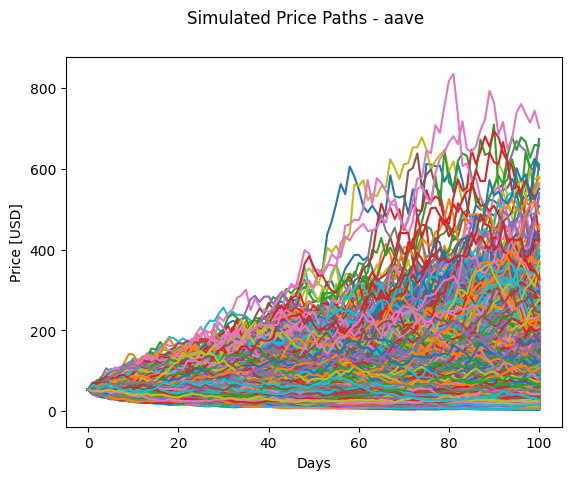

In [5]:
# plot example of Monte Carlo Paths (aave)
from src.plots import plot_mc_paths
from matplotlib import pyplot as plt

symbol = "aave"
price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
paths = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])

fig = plot_mc_paths(symbol, paths)
plt.show()

In [6]:
# Simulate Monte Carlo Paths for all Symbols
mc_paths = {}
for symbol in symbols:
    price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
    mc_paths[symbol] = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])

final_prices = {}
for k, v in mc_paths.items():
    final_prices[k] = mc_paths[k][:,-1].tolist()
df_outcomes = pd.DataFrame(final_prices, index=[f"p{i}" for i in range(params["mc_paths"])]).T
df_outcomes


,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p9990,p9991,p9992,p9993,p9994,p9995,p9996,p9997,p9998,p9999
usdp,1.000100,0.966539,0.984467,1.024630,1.072267,1.070764,0.971479,0.975582,0.985527,0.963499,...,0.980634,0.928975,0.978304,0.958324,0.916511,0.934958,0.963453,0.969500,1.084051,0.986837
tusd,1.070101,0.947980,0.997322,1.024869,0.979648,0.947645,0.996430,0.961986,0.943859,1.038810,...,1.087732,0.983647,0.998507,0.997000,1.011398,1.003368,0.991650,1.039219,1.020208,1.005101
rep,12.652317,3.466904,31.413142,2.625434,15.026136,13.910967,8.716057,6.096853,8.862329,3.372837,...,4.014546,9.442138,9.692258,4.648170,4.344922,8.918691,4.525842,9.646293,1.408215,15.416646
uni,8.563262,10.238441,5.887084,3.232529,4.066785,3.207982,1.124111,5.527321,5.818548,9.336489,...,3.765315,3.393733,5.218388,4.429865,7.198101,15.071154,5.929042,4.589813,2.287858,11.144875
usdc,0.991240,0.985765,0.986651,0.973442,1.001816,1.029295,0.988381,0.999335,1.009953,1.011610,...,0.977997,0.950428,1.016318,1.000548,1.020416,0.982339,1.029719,1.029366,1.036411,0.994610
sushi,2.227869,1.669911,0.852945,0.919839,3.022083,0.516241,3.592878,0.139909,0.368664,0.968681,...,0.945235,1.816370,3.025025,0.927843,0.968470,0.627528,2.244780,0.144753,0.839439,0.238620
eth,577.139746,1010.731329,602.430700,1507.579638,759.395996,784.941301,2985.144559,623.047095,1382.361424,979.197513,...,603.881386,928.212945,939.326487,814.079897,1322.305058,585.216402,1534.967815,1650.892324,1053.956223,1967.889905
dai,0.987541,0.998349,0.989305,0.985492,1.012386,1.016494,1.012472,0.966610,0.996346,1.007485,...,0.997628,0.983218,1.027172,0.966556,1.003258,1.009682,0.991883,0.996810,1.000378,1.006730
bat,0.222491,0.062705,0.515609,0.305975,0.262109,0.308894,0.164347,0.241093,0.336071,0.124706,...,0.162419,0.315670,0.352251,0.114680,0.115668,0.093990,0.192456,0.322455,0.232890,0.419249
comp,39.099431,40.515015,42.444052,25.469307,66.339767,31.884527,43.198187,31.127894,39.908784,71.288388,...,69.201287,56.604809,12.489654,53.345234,20.321409,62.309297,8.862070,39.611257,53.869652,10.757910


# Calculate Value of Borrows and Supplies

- value of cTokens in USD: `amount_cToken * exchange_rate * price_usd`
- value of Supply: `supply_value * collateralFactor`
- value of Borrow: `borrow_value`

## VaR
For the Value at Risk, I handled the protocol like a portfolio. The current value $V(t_{0})$ of the portfolio is:

$V(t_{0}) = \sum_{assets} (supply\_value(t_{0}) - borrow\_value(t_{0}))$

Then the N paths with horizon $h$ are simulated for each asset and we get N potential values of the portfolio in the future. 
(same calculatian as before, only with simulated `price_usd`)

$V_{k}(t_{h}) = \sum_{assets} (supply\_value(t_{h}) - borrow\_value(t_{h}))$

From this we can calculate N returns ($R_k = V_{k}(t_{h})/ V(t_{0}), k=1,...,N$). And look at the distribution of the returns $R_k$.

The VaR is then defined as the .....



In [7]:
def calc_value_usd(n_ctoken, exchange_rate, price_usd):
    return n_ctoken * exchange_rate * price_usd

borrows_df["supplyValue"] = borrows_df.apply(
    lambda row: calc_value_usd(row["totalSupply"], row["exchangeRate"], row["underlyingPriceUSD"]) * row["collateralFactor"], 
    axis=1)
borrows_df["borrowValue"] = borrows_df.apply(
    lambda row: calc_value_usd(row["totalBorrows"], row["exchangeRate"], row["underlyingPriceUSD"]), 
    axis=1) 

print(f"Overal Supply Value: {borrows_df['supplyValue'].sum()}")
print(f"Overal Borrow Value: {borrows_df['borrowValue'].sum()}")
borrows_df

Overal Supply Value: 1472870001.6326773
Overal Borrow Value: 14019602.161921965


,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp,supplyValue,borrowValue
0,ZRX,0x Protocol Token,0.650,0.020591,4.962345e+05,4.944923e+08,0.175700,1669117751,1.162836e+06,1.795282e+03
1,YFI,yearn.finance,0.750,0.020265,3.181422e-02,7.085534e+03,6194.460000,1668777299,6.671040e+05,3.993751e+00
2,WBTC,Wrapped BTC,0.700,0.020072,1.565218e+02,7.824679e+05,15740.040000,1669117607,1.730426e+08,4.944964e+04
4,USDT,Tether USD,0.000,0.022045,1.647356e+08,1.040939e+10,1.000000,1669117127,0.000000e+00,3.631557e+06
5,USDP,Pax Dollar,0.000,0.020194,1.973558e+04,1.473143e+06,1.000000,1669103195,0.000000e+00,3.985426e+02
6,USDC,USD//C,0.855,0.022679,2.569819e+08,2.992931e+10,1.000000,1669118027,5.803528e+08,5.828164e+06
7,UNI,Uniswap,0.750,0.020299,4.302101e+05,2.187284e+08,5.026058,1669117823,1.673700e+07,4.389267e+04
8,TUSD,TrueUSD,0.000,0.020552,5.487149e+06,3.924372e+08,1.000000,1669103147,0.000000e+00,1.127725e+05
9,SUSHI,SushiToken,0.700,0.020470,6.625741e+05,1.403626e+08,1.102776,1669117979,2.217986e+06,1.495698e+04
10,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731,0.000000e+00,7.799562e+00


In [8]:
b = borrows_df[["exchangeRate", "collateralFactor", "totalSupply", "totalBorrows"]]
b.index =[s.lower() for s in borrows_df["underlyingSymbol"].to_list()]
b

,exchangeRate,collateralFactor,totalSupply,totalBorrows
zrx,0.020591,0.650,4.944923e+08,4.962345e+05
yfi,0.020265,0.750,7.085534e+03,3.181422e-02
wbtc,0.020072,0.700,7.824679e+05,1.565218e+02
usdt,0.022045,0.000,1.040939e+10,1.647356e+08
usdp,0.020194,0.000,1.473143e+06,1.973558e+04
usdc,0.022679,0.855,2.992931e+10,2.569819e+08
uni,0.020299,0.750,2.187284e+08,4.302101e+05
tusd,0.020552,0.000,3.924372e+08,5.487149e+06
sushi,0.020470,0.700,1.403626e+08,6.625741e+05
rep,0.020041,0.000,5.470486e+04,5.590882e+01


In [9]:
df = pd.merge(b, df_outcomes, left_index=True, right_index=True)

total_values = {}
for i in range(params["mc_paths"]):
    df[f"supplyValue{i}"] = df.apply(
        lambda row: calc_value_usd(row["totalSupply"], row["exchangeRate"], row[f"p{i}"]) * row["collateralFactor"], 
        axis=1)
    df[f"borrowValue{i}"] = df.apply(
        lambda row: calc_value_usd(row["totalBorrows"], row["exchangeRate"], row[f"p{i}"]), 
        axis=1) 
    total_values[i] = {"supply": df[f"supplyValue{i}"].sum(), "borrow": df[f"borrowValue{i}"].sum()}


In [34]:
import numpy as np
current_value = borrows_df["supplyValue"].sum() - borrows_df["borrowValue"].sum()
print(current_value)

possible_values = pd.DataFrame(total_values).T
possible_values["return"] = (possible_values["supply"] - possible_values["borrow"])/current_value

1458850399.4707553


Text(0.5, 1.0, 'Simulated Portfolio Returns (N=10000)')

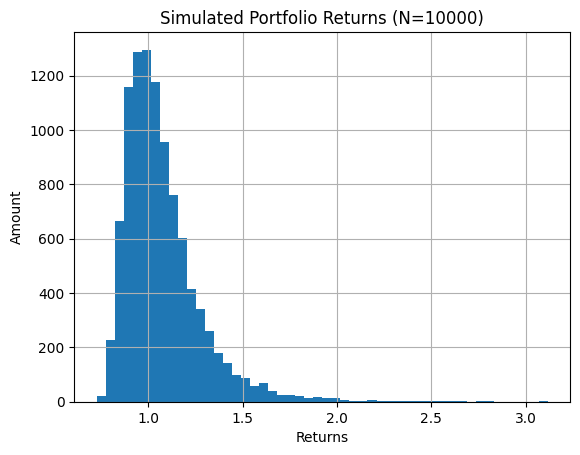

In [43]:
possible_values["return"].hist(bins=50)
plt.xlabel("Returns")
plt.ylabel("Amount")
plt.title(f"Simulated Portfolio Returns (N={params['mc_paths']})")

In [41]:
# return at the 0.05 percentile:
var_critical_return = np.percentile(possible_values["return"], q=params["var_percentile"])
current_value - current_value * var_critical_return

print(f"There is a {int(params['var_percentile']*100)}% chance that the portfolio will have a return of less than {var_critical_return:.4f} within {params['mc_horizon']} days.")


There is a 10% chance that the portfolio will have a return of less than 0.7677 within 100 days
